In [63]:
# most of this code is from the tensorflow tutorial


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import time

tf.enable_eager_execution()

In [66]:
# setting up iris data

train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
feature_names = column_names[:-1]
label_name = column_names[-1]

# print("Features: {}".format(feature_names))
# print("Label: {}".format(label_name))

class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']
batch_size = 32

train_dataset = tf.contrib.data.make_csv_dataset(
    train_dataset_fp,
    batch_size, 
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

features, labels = next(iter(train_dataset))


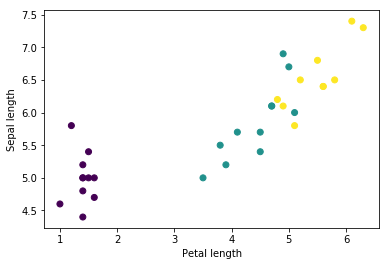

In [46]:
# just some visualization

plt.scatter(features['petal_length'].numpy(),
            features['sepal_length'].numpy(),
            c=labels.numpy(),
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length");

In [67]:
def pack_features_vector(features, labels):
    # Pack the features into a single array.
    features = tf.stack(list(features.values()), axis=1)
    return features, labels

train_dataset = train_dataset.map(pack_features_vector)
features, labels = next(iter(train_dataset))

#print(features[:5])

model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

predictions = model(features)
predictions[:5]

<tf.Tensor: id=107891, shape=(5, 3), dtype=float32, numpy=
array([[ 2.9926596,  1.3439149, -4.3394327],
       [ 3.1009972,  1.3590363, -4.481715 ],
       [ 3.9792027,  1.4933509, -5.458959 ],
       [ 3.5490193,  1.4462588, -5.1911664],
       [ 4.6242404,  1.9845191, -6.709637 ]], dtype=float32)>

In [52]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: id=556, shape=(5, 3), dtype=float32, numpy=
array([[0.8397675 , 0.14426102, 0.01597159],
       [0.80894226, 0.16642734, 0.02463042],
       [0.79582053, 0.17438565, 0.02979387],
       [0.82938474, 0.12327821, 0.04733705],
       [0.87406254, 0.09401252, 0.03192494]], dtype=float32)>

In [53]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
    Labels: [2 2 1 0 0 0 2 2 0 1 1 0 0 2 2 2 1 0 0 0 0 1 2 2 1 2 1 1 1 1 1 0]


In [54]:
def loss(model, x, y):
    y_ = model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: 1.7843706607818604


In [56]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
global_step = tf.Variable(0)
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step)

print("Step: {},         Loss: {}".format(global_step.numpy(),
                                          loss(model, features, labels).numpy()))

In [68]:
## Note: Rerunning this cell uses the same model variables

from tensorflow import contrib
tfe = contrib.eager

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()

  # Training loop - using batches of 32
    for x, y in train_dataset:
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables),
                                  global_step)

        # Track progress
        epoch_loss_avg(loss_value)  # add current batch loss
        # compare predicted label to actual label
        epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

    # end epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 3.767, Accuracy: 35.833%
Epoch 050: Loss: 0.731, Accuracy: 68.333%
Epoch 100: Loss: 0.492, Accuracy: 85.000%
Epoch 150: Loss: 0.376, Accuracy: 88.333%
Epoch 200: Loss: 0.274, Accuracy: 95.000%


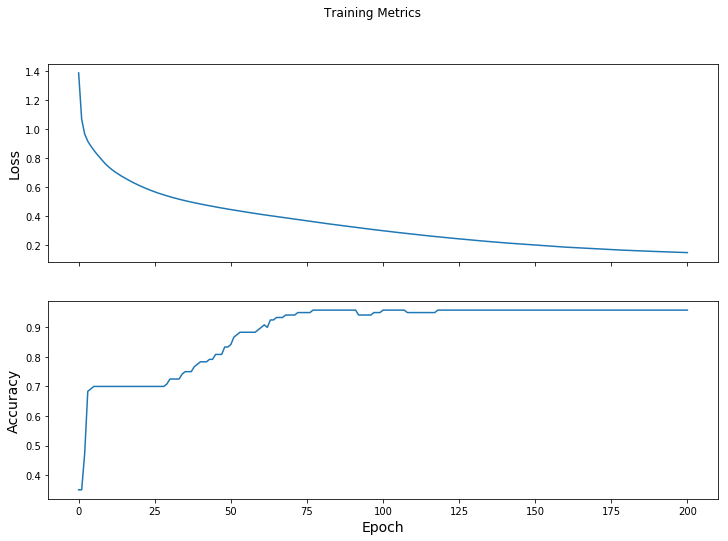

In [59]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results);

In [60]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 3us/step


In [61]:
test_dataset = tf.contrib.data.make_csv_dataset(
    test_fp,
    batch_size, 
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

In [62]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%
